In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = xr.open_dataset('/work/bb1166/Edward/WRFOUT/IRENE/postproc/wrfout_SENEGAL_2019full_d03_v2.nc')
ds

<xarray.Dataset>
Dimensions:    (Time: 345601, lat: 222, lon: 399)
Coordinates:
  * Time       (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-29T00:01:00
  * lat        (lat) float32 13.7 13.71 13.72 13.73 ... 15.66 15.67 15.68 15.69
  * lon        (lon) float32 -18.2 -18.19 -18.18 -18.17 ... -14.52 -14.51 -14.5
Data variables:
    RAIN_1MIN  (Time, lat, lon) float32 ...
    RAINNC     (Time, lat, lon) float32 ...
    I_RAINNC   (Time, lat, lon) float32 ...
    T2         (Time, lat, lon) float32 ...
    SMOIS      (Time, lat, lon) float32 ...
    Q2         (Time, lat, lon) float32 ...
    PSFC       (Time, lat, lon) float32 ...
    U10        (Time, lat, lon) float32 ...
    V10        (Time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.9

In [4]:
stations = dict(
    Pout=(14.763706039562928, -17.066131173817304),
    Dakar=(14.729758635332256, -17.47)
)

variables = ["T2", "RAIN_1MIN", "Q2", "SMOIS", "U10", "V10", "PSFC"]

station_datasets = []
for station_name, latlon in stations.items():
    print(station_name, latlon)
    lat, lon = latlon
    ds_station = ds.sel(lat=lat, lon=lon, method="nearest")[variables].chunk(Time=512)
    ds_station.coords["station_name"] = station_name
    station_datasets.append(ds_station)
    
ds_stations_data = xr.concat(station_datasets, dim="station_name")

ds_stations_data

Pout (14.763706039562928, -17.066131173817304)
Dakar (14.729758635332256, -17.47)


<xarray.Dataset>
Dimensions:       (station_name: 2, Time: 345601)
Coordinates:
  * Time          (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-29T00...
    lat           (station_name) float32 14.76 14.73
    lon           (station_name) float32 -17.07 -17.47
  * station_name  (station_name) <U5 'Pout' 'Dakar'
Data variables:
    T2            (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    RAIN_1MIN     (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    Q2            (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    SMOIS         (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    U10           (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    V10           (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    PSFC          (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.9

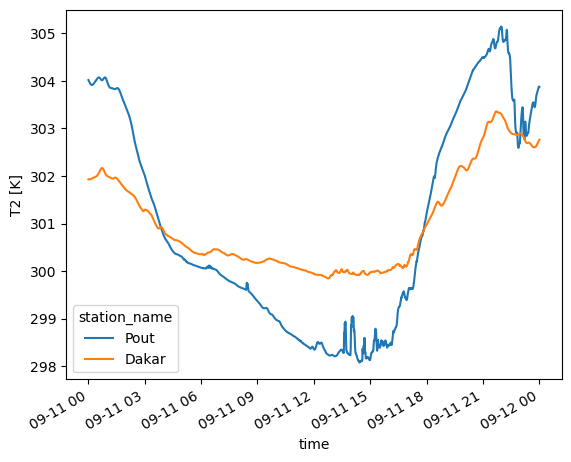

In [5]:
ds_stations_data.T2.sel(Time=slice('2019-09-11T00:01:00', '2019-09-12T00:00:00')).plot(hue='station_name')

In [6]:
# Setting 80 percent data for training

ds = ds_stations_data.T2.sel(Time=slice('2019-09-01T00:00:00', '2019-09-05T00:00:00')).sel(station_name='Dakar')
training_data_len = math.ceil(len(ds.Time) * 0.8)

# Splitting the dataset
train_data = ds.isel(Time=slice(0, training_data_len))
test_data = ds.isel(Time=slice(training_data_len, None))

print(train_data.shape, test_data.shape)



(4609,) (1152,)


In [7]:
dataset_train = np.reshape(train_data.values, (-1,1))

In [8]:
dataset_test = np.reshape(test_data.values, (-1,1))

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.44373322]
 [0.44158173]
 [0.43936157]
 [0.43639374]
 [0.43549347]]
[0.43543625] [0.4340477] [0.4338684] [0.43323898] [0.43154144]


In [10]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([4559, 50, 1]), torch.Size([4559, 50, 1]))

In [30]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([1122, 30, 1]), torch.Size([1122, 30, 1]))

In [31]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [14]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
batch_X, batch_y = next(iter(train_loader))
batch_X.shape, batch_y.shape

(torch.Size([16, 50, 1]), torch.Size([16, 50, 1]))

In [44]:
batch_yhat = model(batch_X)
batch_yhat.shape

torch.Size([16, 50, 1])

In [45]:
tn_input, tn_output

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]))

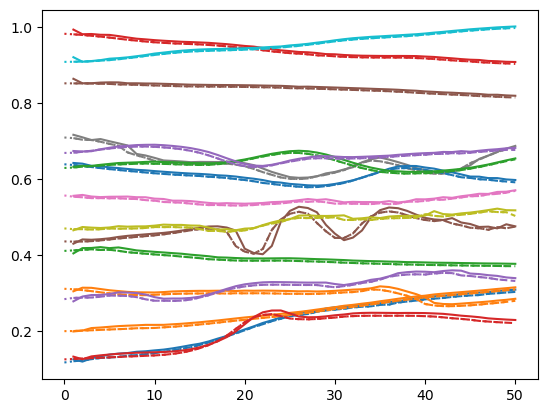

In [48]:
fig, ax = plt.subplots()
n_input = batch_X.shape[1]
n_output = batch_y.shape[1]
for i in range(batch_size):
    tn_input = np.arange(n_input)
    tn_output = np.arange(1, n_input+1)
    l, = ax.plot(tn_input, batch_X[i,:,0], linestyle=":")
    ax.plot(tn_output, batch_y[i,:,0], color=l.get_color(), linestyle="--")
    ax.plot(tn_output, batch_yhat[i,:,0].detach().numpy(), color=l.get_color(), linestyle="-")

In [38]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0000, Test Loss: 0.0000


KeyboardInterrupt: 

In [49]:
train_hist

[0.01675404602612712,
 0.0018008819121556978,
 0.0005935597854355971,
 0.00025540907464394544,
 0.00010827075856739835,
 3.932545317806408e-05,
 2.596430288241735e-05,
 2.6020530999391523e-05,
 2.51022040334136e-05,
 2.8835592450361635e-05,
 2.5024902166287096e-05]

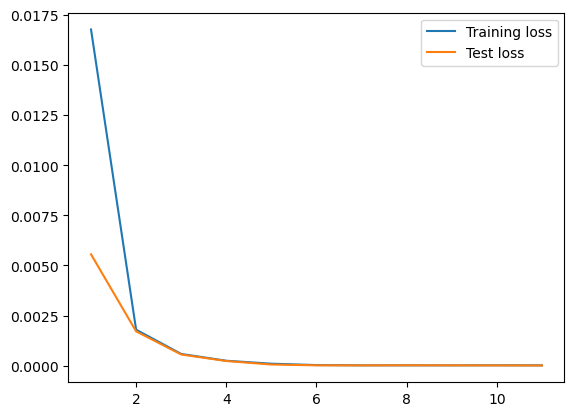

In [40]:
x = np.linspace(1,len(train_hist),len(train_hist))
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

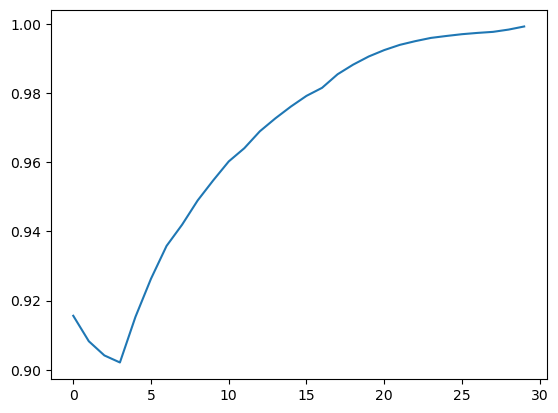

In [74]:

# Assuming you have your X_test, model, and device defined before this point

# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to xarray and remove singleton dimensions
sequence_to_plot = xr.DataArray(X_test.squeeze().cpu().numpy(), dims=['Time','step'])
#X_test.squeeze().cpu().numpy().shape
historical_data = sequence_to_plot.isel(Time=-1).values
plt.plot(historical_data)

In [75]:
historical_data

array([0.9156265 , 0.90826416, 0.9041672 , 0.9021301 , 0.9153137 ,
       0.9263382 , 0.9358063 , 0.94194794, 0.9489441 , 0.95474243,
       0.96022415, 0.96403885, 0.9689293 , 0.9726753 , 0.9760895 ,
       0.97916794, 0.98148346, 0.9854088 , 0.9881897 , 0.99053955,
       0.9923935 , 0.9939003 , 0.99497986, 0.99591064, 0.9964714 ,
       0.9969864 , 0.9973564 , 0.9976616 , 0.9983177 , 0.9992142 ],
      dtype=float32)

In [69]:

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(100): #num_forecast_steps * 2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)

        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Generate future dates
last_date = test_data.isel(Time=-1).Time
last_date.values

numpy.datetime64('2019-09-05T00:00:00.000000000')

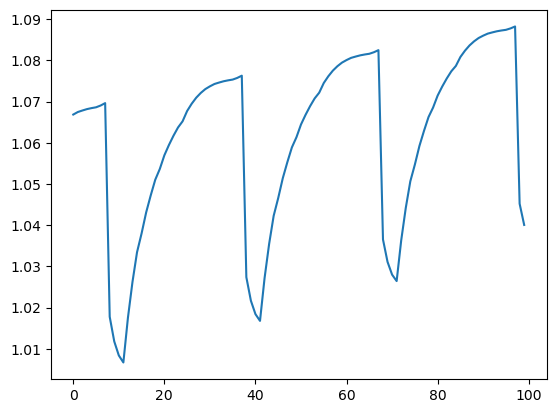

In [73]:
fig, ax = plt.subplots()
#print(forecasted_values)
ax.plot(forecasted_values)

In [19]:
# Generate the next 30 dates
time = pd.date_range(start=last_date.values, freq='min', periods=30)

future_dates = xr.DataArray(time,dims=("Time"))


# Concatenate the original index with the future dates
combined_index = xr.concat([test_data.Time, future_dates],dim='Time')
combined_index 
#test_data.Time
#sequence_to_plot
#future_dates

<xarray.DataArray 'Time' (Time: 1182)>
array(['2019-09-04T04:49:00.000000000', '2019-09-04T04:50:00.000000000',
       '2019-09-04T04:51:00.000000000', ...,
       '2019-09-05T00:27:00.000000000', '2019-09-05T00:28:00.000000000',
       '2019-09-05T00:29:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * Time          (Time) datetime64[ns] 2019-09-04T04:49:00 ... 2019-09-05T00...
    lat           float32 14.73
    lon           float32 -17.47
    station_name  <U5 'Dakar'
Attributes:
    standard_name:  time
    axis:           T

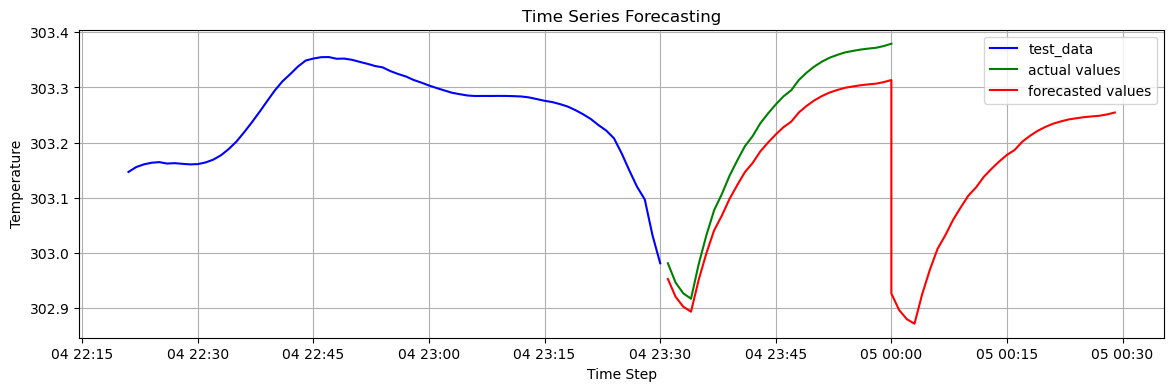

In [20]:

# set the size of the plot
plt.rcParams['figure.figsize'] = [14, 4]

# Test data
plt.plot(test_data.isel(Time=slice(-100, -30)).Time, test_data.isel(Time=slice(-100, -30)), label="test_data", color="b")

# Reverse the scaling transformation for original cases
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

# Plot the historical data used as input for forecasting
plt.plot(test_data.isel(Time=slice(-30, None)).Time, original_cases, label='actual values', color='green')

# Forecasted Values
# Reverse the scaling transformation for forecasted cases
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# Plotting the forecasted values
plt.plot(combined_index.isel(Time=slice(-60, None)).Time, forecasted_cases, label='forecasted values', color='red')


plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()


In [ ]:
# The original data:

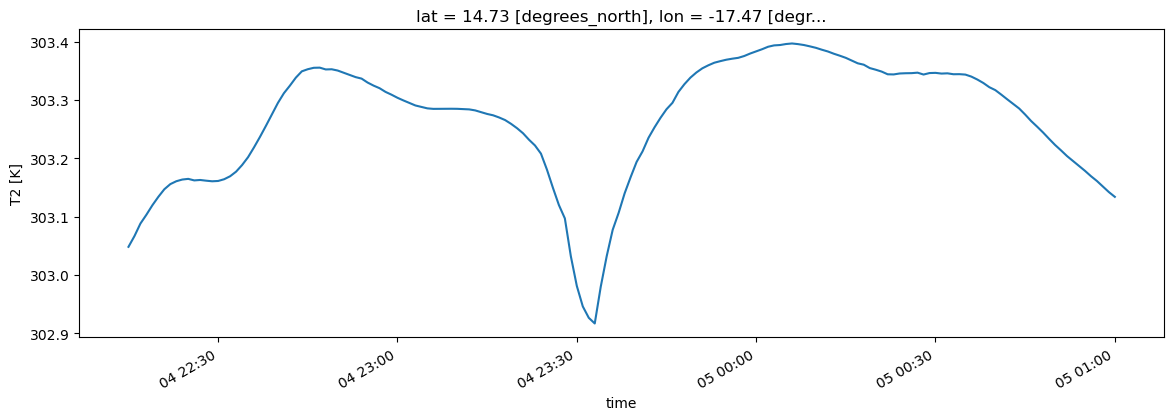

In [21]:

ds_stations_data.T2.sel(Time=slice('2019-09-04T22:15:00', '2019-09-05T01:00:00')).sel(station_name='Dakar').plot()

In [78]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(15, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [79]:
output.shape

torch.Size([15, 3, 20])